# Formant estimation by AR model

Human voice is constructed from two factors:

- **glottal source**, buzz-like sound generated by vocal cords, and
- **vocal tract filtering** by lips, a throat, a nasal cavity, etc.

[Formant](https://en.wikipedia.org/wiki/Formant) is peak of power spectrum of the vocal tract filter.
It is important information applied to speech recognition, and voice synthesis.
Especially, low-frequency formant frequencies describe features of vowel sounds.

In this example, we show estimation of formants of five kinds of voewl sound
/&#97;/, /&#105;/, /&#623;/, /&#600;/, and /&#596;/ by autoregressive (AR) model.

In [1]:
#thread ;;
#require "core,fftw3,jupyter-archimedes" ;;
#use "wav.ml" ;;
#print_length 30 ;; (* Omit printing too long array *)

Module Archimedes loaded and aliased as A.


module Wav :
  sig
    type t = [ `Monoral of float array | `Stereo of (float * float) array ]
    val from_string : string -> int * t
    val from_channel : in_channel -> int * t
    val from_file : string -> int * t
    val to_file : ?sample_bits:int -> sample_rate:int -> string -> t -> unit
  end


In [2]:
open Core ;;
open Core.Caml.Format ;;

let pi = 3.14159265358979 ;;

val pi : float = 3.14159265358979


# Preliminaries

We use an audio file of vowel sound **/a/** downloaded from Wikipedia.
The original data format is OGG, but it is not easy to read and write due to compression.
We convert OGG files into (non-compressed) linear-PCM WAV files by FFmpeg.

FFmpeg options:

- `-ac 1`: output monoral data
- `-ar N`: set $N$ to sample rate
- `-acodec pcm_s16le`: output linear PCM of litte-endian 16-bit signed integers
- `-loglevel warning`: supress noisy logging
- `-y`: always YES (overwrite a file of the same name)

In [ ]:
let read_sound_file fname url =
  assert(Unix.system (sprintf "curl -o %s -sL %s" fname url) = Ok ()) ;
  assert(Unix.system (sprintf "ffmpeg -loglevel warning -y -i %s -ac 1 -acodec pcm_s16le %s.wav" fname fname) = Ok ()) ;
  match Wav.from_file (fname ^ ".wav") with
  | (_, `Stereo _) -> assert false (* We assume all sound files are monoral! *)
  | (sample_rate, `Monoral xs) ->
    let txs = Array.mapi xs ~f:(fun i x -> (float i /. float sample_rate, x)) in (* pairs of time and x *)
    (sample_rate, txs)
;;

let (sample_rate, raw_signal) =
  read_sound_file
    "datasets/a.ogg"
    "https://upload.wikimedia.org/wikipedia/commons/6/65/Open_front_unrounded_vowel.ogg" ;;

val read_sound_file : string -> string -> int * (float * float) Core.Array.t =
  <fun>


val sample_rate : int = 44100
val raw_signal : (float * float) Core.Array.t =
  [|(0., 0.); (2.26757369614512476e-05, 0.001129150390625);
    (4.53514739229024953e-05, 0.002197265625);
    (6.80272108843537395e-05, 0.002960205078125);
    (9.07029478458049905e-05, 0.002655029296875);
    (0.000113378684807256242, 0.001312255859375);
    (0.000136054421768707479, 0.0008544921875);
    (0.00015873015873015873, 0.001007080078125);
    (0.000181405895691609981, 0.000274658203125); ...|]


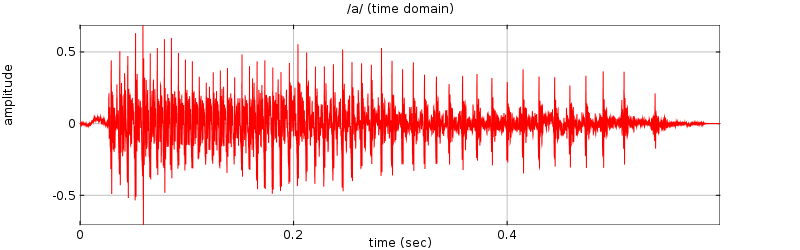

- : unit = ()


In [4]:
let vp = A.init ~w:800. ~h:250. ["jupyter"] in
A.Axes.box vp ;
A.Viewport.title vp "/a/ (time domain)" ;
A.Viewport.xlabel vp "time (sec)" ;
A.Viewport.ylabel vp "amplitude" ;
A.set_color vp A.Color.red ;
A.Array.xy_pairs vp ~style:`Lines raw_signal ;
A.close vp

# Preprocessing

In this example, we extract a sub-array of index 15000 to 20000, and apply the hamming window:

$$w(i) = 0.54 - 0.46 \cos\left( \frac{2 \pi i}{N-1} \right).$$

In [5]:
let hamming_window x =
  let n = 5000 in
  let hamming i = 0.54 -. 0.46 *. Float.cos (2.0 *. pi *. float i /. float (n - 1)) in
  Array.sub ~pos:15000 ~len:n x
  |> Array.mapi ~f:(fun i (t, x) -> (t, x *. hamming i))
;;

let win_signal = hamming_window raw_signal ;;

val hamming_window : ('a * float) Core.Array.t -> ('a * float) Core.Array.t =
  <fun>


val win_signal : (float * float) Core.Array.t =
  [|(0.340136054421768697, 0.00372802734375000076);
    (0.34015873015873016, 0.00268800048964651);
    (0.340181405895691624, 0.0014087169984098708);
    (0.340204081632653088, 0.000361342894815645202);
    (0.340226757369614496, -0.0002954316234697735);
    (0.34024943310657596, -0.000712971570515843079);
    (0.340272108843537424, -0.00116474119143974964);
    (0.340294784580498888, -0.00167029351353935166);
    (0.340317460317460296, -0.00214661988108693367); ...|]


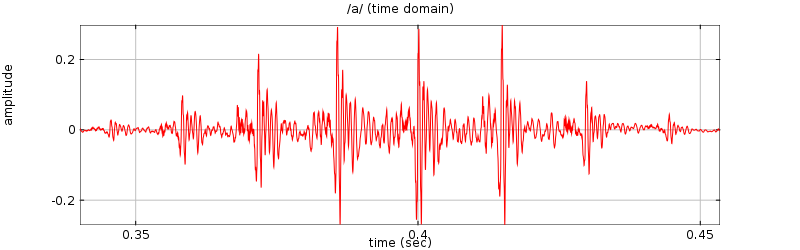

- : unit = ()


In [6]:
let vp = A.init ~w:800. ~h:250. ["jupyter"] in
A.Axes.box vp ;
A.Viewport.title vp "/a/ (time domain)" ;
A.Viewport.xlabel vp "time (sec)" ;
A.Viewport.ylabel vp "amplitude" ;
A.set_color vp A.Color.red ;
A.Array.xy_pairs vp ~style:`Lines win_signal ;
A.close vp

# Power spectrum

In [7]:
let fft_spectrum ~sample_rate xs =
  let module FFT = Fftw3.D in
  let open Bigarray in
  let n = Array.length xs in
  let c_xs = Array1.create FFT.complex C_layout n in (* source memory for time-domain data *)
  let c_zs = Array1.create FFT.complex C_layout n in (* destination memory for frequency-domain data *)
  let plan = FFT.Array1.dft FFT.Forward c_xs c_zs in
  for i = 0 to n - 1 do
    let x = xs.(i) in
    c_xs.{i} <- Complex.({ re = x; im = 0.0; })
  done ;
  FFT.exec plan ; (* Execute FFT *)
  Array.init (n / 2)
    ~f:(fun i ->
        let f = float i /. float n *. float sample_rate in (* frequency *)
        let db = 10.0 *. Float.log10 (Complex.norm2 c_zs.{i}) in (* Convert into power spectrum (decibels) *)
        (f, db))
;;
let spectrum = fft_spectrum ~sample_rate @@ Array.map ~f:snd win_signal ;;

val fft_spectrum :
  sample_rate:int -> float Core.Array.t -> (float * float) Core.Array.t =
  <fun>


val spectrum : (float * float) Core.Array.t =
  [|(0., -16.3981659621761686); (8.82, 10.54702919071614);
    (17.64, 12.9381493850392832); (26.4599999999999973, 3.10820173803326849);
    (35.28, 10.1225596086416267); (44.1, 15.3572463641570671);
    (52.9199999999999946, 6.31669095414016724); (61.74, 12.5306958973086893);
    (70.56, 13.579175394292422); ...|]


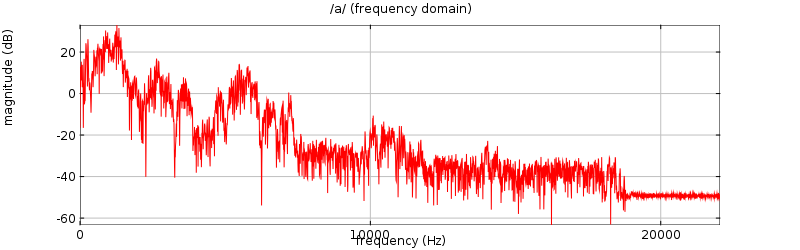

- : unit = ()


In [8]:
let vp = A.init ~w:800. ~h:250. ["jupyter"] in
A.Axes.box vp ;
A.Viewport.title vp "/a/ (frequency domain)" ;
A.Viewport.xlabel vp "frequency (Hz)" ;
A.Viewport.ylabel vp "magnitude (dB)" ;
A.set_color vp A.Color.red ;
A.Array.xy_pairs vp ~style:`Lines spectrum ;
A.close vp

# Auroregressive model

Let $x_t \in \mathbb{R}$ be a signal of vowel sound, and $t = 1,\dots,N$ be a time step.
Autoregressive (AR) model assumes that $x_t$ is represented by

$$x_t = - \sum^{k}_{i=1} a_i x_{t-i} + \varepsilon_t$$

where $k \in \mathbb{N}$ is the _AR order_, and
$\varepsilon_t \sim \mathcal{N}(0, \sigma^2)$ is an error at time $t$.
AR model is [IIR filter](https://en.wikipedia.org/wiki/Infinite_impulse_response)
generating $x_t$ from Gaussian noise $\varepsilon_t$, i.e.,

- $a_i$ is voice tract filter coefficients,
- $\varepsilon_t$ is a glottal source, and
- $x_t$ is observed voice sound.

## Levinson-Durvin recursion

Levinson-Durbin recursion is approach for estimation of AR coefficients $a_i$ by the minimization of $\sigma^2$.
The algorithm computes AR($m+1$) coefficients $a^{(m+1)}_i$ and $\sigma^2_{(m+1)}$
from AR($m$) parameters $a^{(m)}_i$ and $\sigma^2_{(m)}$, recusively.
The detailed derivation is explained in [this tutorial](http://www.emptyloop.com/technotes/A%20tutorial%20on%20linear%20prediction%20and%20Levinson-Durbin.pdf).

First, we obtain $\sigma^2_{(0)}$ under the assumption that $x_t$ is Gaussian noise $\varepsilon_t$:

$$\sigma^2_{(0)} = R(0).$$

Second, we recursively calculate $a^{(m+1)}_i$ and $\sigma^2_{(m+1)}$ by

\begin{align}
  \lambda_{(m+1)} & = - \left( R(m) + \sum^m_{i=1} a_i^{(m)} R(m+1-i) \right) \sigma^{-2}_{(m)}, \\
  a^{(m+1)}_i & = a^{(m)}_i + \lambda_{(m+1)} a^{(m)}_{m-i}, \qquad (i = 1,\dots,m) \\
  a^{(m+1)}_{m+1} & = \lambda_{(m+1)}, \\
  \sigma^2_{(m+1)} & = \left( 1 - \lambda_{(m+1)}^2 \right) \sigma^2_{(m)}.
\end{align}

In [9]:
let levinson r =
  let n = Array.length r in
  if n = 0 then failwith "levinson: empty autocorrelation" ;
  let rec aux m ar sigma2 =
    if m + 1 = n then (ar, sigma2)
    else begin
      let lambda = ~-. (Array.foldi ~init:r.(m + 1) ~f:(fun i acc ai -> acc +. ai *. r.(m - i)) ar) /. sigma2 in
      let ar' = Array.init ~f:(fun i -> if i = m then lambda else ar.(i) +. lambda *. ar.(m - i - 1)) (m + 1) in
      let sigma2' = sigma2 *. (1.0 -. lambda *. lambda) in
      aux (m + 1) ar' sigma2'
    end
  in
  aux 0 [||] r.(0)

val levinson : float Core.Array.t -> float Core.Array.t * float = <fun>


where $R(\tau)$ is autocorrelation of $x_t$ given by

$$R(\tau) = \sum^{N-\tau}_{t=1} x_t x_{t+\tau} \quad (\tau \ge 0).$$

In [10]:
let autocorr ~max_lag x =
  let n = Array.length x in
  Array.init (max_lag + 1)
    ~f:(fun lag ->
        let sum = ref 0.0 in
        for i = 0 to n - lag - 1 do sum := !sum +. x.(i) *. x.(i + lag) done ;
        !sum)

val autocorr : max_lag:int -> float Core.Array.t -> float Core.Array.t =
  <fun>


In [11]:
let (ar, sigma2) = levinson @@ autocorr ~max_lag:60 @@ Array.map ~f:snd win_signal

val ar : float Core.Array.t =
  [|-3.15488819100091433; 4.39693011682255186; -4.03894703717712478;
    3.51162541376807491; -3.42527195508538274; 3.19806748888310555;
    -2.84333748436180533; 2.27983966767366919; -1.13920665663205334;
    0.300301176361091771; 0.0431275062420504174; -0.771292371371321894;
    1.399309995860061; -1.16832669639398556; 0.678766574647057;
    -0.558863651769131442; 0.43623797325028113; -0.0389132567919332206;
    -0.290126910165048379; 0.640423369276837; -0.884529470231625758;
    0.721720695613261132; -0.406037068450769922; 0.0696315933770184775;
    0.176825152668555252; -0.267361992363075729; 0.333013962989415824; ...|]
val sigma2 : float = 0.00419180662910843826


# Spectrum envelope

AR model is an IIR filter generating $x_t$ from Gaussian noise $\varepsilon_t$:

$$\varepsilon_t = x_t + \sum^k_{i=1} a_i x_{t-i} = \sum^k_{i=0} a_i x_{t-i}$$

where $a_0 = 1$.
Let

- $A(\omega)$ be a voice tract filter characteristics, i.e., a spectrum of $a_i$,
- $E(\omega)$ be a spectrum of glottal source $\varepsilon_t$, and
- $X(\omega)$ is a spectrum of observed voice sound $x_t$,

then

$$E(\omega) = A(\omega) X(\omega)$$

thus

$$X(\omega) = \frac{E(\omega)}{A(\omega)}.$$

The decibels of power spectrum of $x_t$ is

$$10 \log_{10} |X(\omega)|^2
= 10 \log_{10} \left| \frac{E(\omega)}{A(\omega)} \right|^2
= 10 \log_{10} \frac{\sigma^2}{|A(\omega)|^2}
= 10 \log_{10} \sigma^2 - 10 \log_{10} |A(\omega)|^2.$$

$|A(\omega)|^2$ is called _spectrum envelope_ of $|X(\omega)|^2$.

In [12]:
let spectrum_envelope ~sample_rate ~n ar sigma2 =
  Array.init n ~f:(fun i -> if i = 0 then 1.0 else if i <= Array.length ar then ar.(i - 1) else 0.0)
  |> fft_spectrum ~sample_rate
  |> Array.map ~f:(fun (f, z) -> (f, 10.0 *. Float.log10 sigma2 -. z))
;;
let spec_env = spectrum_envelope ~sample_rate ~n:(Array.length win_signal) ar sigma2 ;;

val spectrum_envelope :
  sample_rate:int ->
  n:int -> float Core.Array.t -> Core.Float.t -> (float * float) Core.Array.t =
  <fun>


val spec_env : (float * float) Core.Array.t =
  [|(0., 15.5233067810192189); (8.82, 15.5224565835314117);
    (17.64, 15.5199169330772939); (26.4599999999999973, 15.5157205136922549);
    (35.28, 15.509921329256219); (44.1, 15.5025940123619925);
    (52.9199999999999946, 15.4938328823598077); (61.74, 15.4837507768561231);
    (70.56, 15.4724776859199089); ...|]


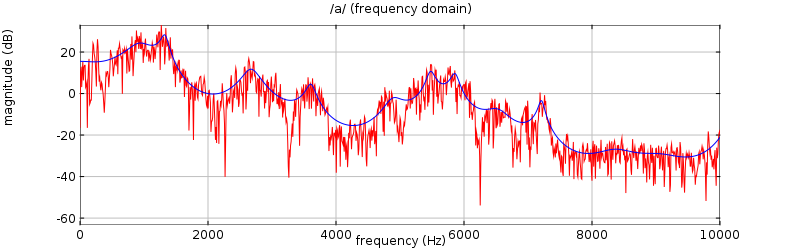

- : unit = ()


In [13]:
let vp = A.init ~w:800. ~h:250. ["jupyter"] in
A.Axes.box vp ;
A.Viewport.title vp "/a/ (frequency domain)" ;
A.Viewport.xrange vp 0.0 10000.0 ;
A.Viewport.xlabel vp "frequency (Hz)" ;
A.Viewport.ylabel vp "magnitude (dB)" ;

(* Spectrum: log |X(w)|^2 *)
A.set_color vp A.Color.red ;
A.Array.xy_pairs vp ~style:`Lines spectrum ;

(* Spectrum envelope: log |A(w)|^2 *)
A.set_color vp A.Color.blue ;
A.Array.xy_pairs vp ~style:`Lines spec_env ;

A.close vp

# Formant frequency

Formant frequency is a peak of a spectrum envelope.

In [14]:
(** [extract_peaks z] returns an array of formant frequencies from a given spectrum envlope [z]. *)
let extract_peaks z =
  let peaks = ref [] in
  for i = 1 to Array.length z - 2 do
    if snd z.(i-1) < snd z.(i) && snd z.(i) > snd z.(i+1) then begin
      peaks := (fst z.(i)) :: !peaks
    end
  done ;
  List.rev !peaks
;;

let formant = extract_peaks spec_env ;;

val extract_peaks : ('a * 'b) Core.Array.t -> 'a Core.List.t = <fun>


val formant : float Core.List.t =
  [943.739999999999895; 1323.; 2672.46; 3607.38; 4921.56; 5486.04;
   5856.48000000000047; 6473.88000000000102; 7205.94; 8370.18; 10125.36;
   10725.12; 12753.7200000000012; 14050.26; 15796.62; 16511.04; 17066.7;
   17745.84; 18363.239999999998; 19580.4; 20427.12; 21229.739999999998]


# Vowel chart

Plot a [vowel chart](https://en.wikipedia.org/wiki/Vowel) of five kinds of voewl sound
/&#97;/, /&#105;/, /&#623;/, /&#600;/, and /&#596;/.

In [15]:
let formants = 
  List.filter_map [
      "a", "https://upload.wikimedia.org/wikipedia/commons/6/65/Open_front_unrounded_vowel.ogg";
      "i", "https://upload.wikimedia.org/wikipedia/commons/9/91/Close_front_unrounded_vowel.ogg";
      "w", "https://upload.wikimedia.org/wikipedia/commons/e/e8/Close_back_unrounded_vowel.ogg";
      "e", "https://upload.wikimedia.org/wikipedia/commons/e/e0/Mid_front_unrounded_vowel.ogg";
      "o", "https://upload.wikimedia.org/wikipedia/commons/0/02/Open-mid_back_rounded_vowel.ogg";
    ]
  ~f:(fun (name, url) ->
      printf "Downloading %s...@." url ;
      let (sample_rate, x) = read_sound_file (sprintf "datasets/%s.ogg" name) url in
      let x' = hamming_window x in
      let (ar, sigma2) = levinson @@ autocorr ~max_lag:60 @@ Array.map ~f:snd x' in
      let spec_env = spectrum_envelope ~sample_rate ~n:(Array.length x') ar sigma2 in
      match extract_peaks spec_env with
      | f1 :: f2 :: _ -> Some (name, f1, f2)
      | _ -> None)

val formants : (string * float * float) Core.List.t =
  [("a", 943.739999999999895, 1323.);
   ("i", 211.679999999999978, 2584.25999999999976); ("w", 246.96, 1111.32);
   ("e", 299.88, 1852.2); ("o", 432.18, 590.94)]


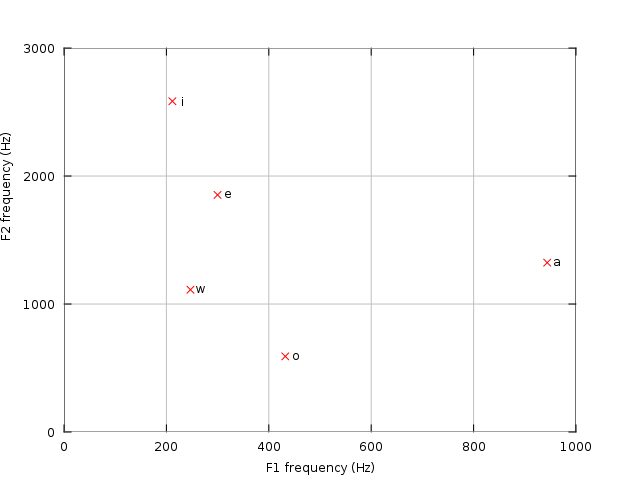

- : unit = ()


In [16]:
let vp = A.init ["jupyter"] in
A.Axes.box vp ;
A.Viewport.xrange vp 0. 1000. ;
A.Viewport.yrange vp 0. 3000. ;
A.Viewport.xlabel vp "F1 frequency (Hz)" ;
A.Viewport.ylabel vp "F2 frequency (Hz)" ;

A.set_color vp A.Color.red ;
A.List.xy_pairs vp ~style:(`Markers "x") (List.map formants ~f:(fun (_, f1, f2) -> (f1, f2))) ;

A.set_color vp A.Color.black ;
List.iter formants ~f:(fun (name, f1, f2) -> A.Viewport.text vp (f1 +. 20.0) f2 name) ;

A.close vp